# Centralized learning for ECG Arrhythmia detection

In [1]:
import os
from pathlib import Path

import lightning as L
import matplotlib.pyplot as plt
import wandb
from dotenv import load_dotenv
from lightning.pytorch.callbacks import (EarlyStopping, ModelCheckpoint,
                                         TQDMProgressBar)
from lightning.pytorch.loggers import TensorBoardLogger, WandbLogger
from sklearn.metrics import classification_report

from dataset_utils import Cinc2017DataModule
from model import DenseNetGruEcgModule

/home/g113056077/.pyenv/versions/ecg-fl/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Config

In [2]:
load_dotenv()
wandb_mode = os.getenv("WANDB_MODE")
MAX_EPOCHS = 50

## Prepare the Dataset

In [3]:
dm = Cinc2017DataModule(batch_size=64)

## Create the Model

In [4]:
model = DenseNetGruEcgModule(
    growth_rate=16,
    block_config=(4, 4, 4, 4, 12, 8, 8, 8, 8),
    num_init_features=64,
    bn_size=4,
    drop_rate=0.3,
    gru_drop_rate=0.3,
    fc_drop_rate=0.5,
    num_classes=dm.num_classes,
    memory_efficient=False,
    compression_factor=0.5,
    lr=1e-3,
    max_epochs = MAX_EPOCHS
)
## Create the Trainer

In [5]:
checkpoint_callback = ModelCheckpoint(
    monitor="valid_loss",
    verbose=True,
    mode="min",
    save_top_k=1,
    save_last=True,
)

# early_stopping_callback = EarlyStopping(
#     monitor="valid_loss", patience=8, verbose=True, mode="min"
# )

progress_bar_callback = TQDMProgressBar(leave=True)

if wandb_mode == 'disabled':
    logger = TensorBoardLogger(save_dir=Path('tb_logs'), name='ecg-centralized')
else:
    logger = WandbLogger(project='ecg-centralized', save_dir=Path('wandb_logs'), log_model=True)
    logger.experiment.name = "ecg-centralized"

trainer = L.Trainer(
    max_epochs=MAX_EPOCHS,
    callbacks=[checkpoint_callback, progress_bar_callback],
    logger=logger,
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: devilhyt. Use `wandb login --relogin` to force relogin


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


## Train the Model

In [6]:
trainer.fit(model, datamodule=dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                      | Params | Mode  | In sizes     | Out sizes
-----------------------------------------------------------------------------------------------
0 | model         | DenseNetGruEcg            | 3.5 M  | train | [1, 1, 6000] | [1, 3]   
1 | loss_fn       | CrossEntropyLoss          | 0      | train | ?            | ?        
2 | train_metrics | MetricCollection          | 0      | train | ?            | ?        
3 | valid_metrics | MetricCollection          | 0      | train | ?            | ?        
4 | test_metrics  | MetricCollection          | 0      | train | ?            | ?        
5 | valid_cm      | MulticlassConfusionMatrix | 0      | train | ?            | ?        
6 | test_cm       | MulticlassConfusionMatrix | 0      | train | ?            | ?        
-----------------------------------------------------------------------------------------------
3.5 M     Trainable params
0         Non-trai

Training: |          | 0/? [00:00<?, ?it/s]                                
Epoch 0: 100%|██████████| 91/91 [00:13<00:00,  6.55it/s, v_num=v7zn, lr=0.001, valid_loss=0.956, valid_acc=0.355, valid_f1=0.311, train_loss=1.090, train_acc=0.375, train_f1=0.371]

Epoch 0, global step 91: 'valid_loss' reached 0.95646 (best 0.95646), saving model to 'wandb_logs/ecg-centralized/1rk5v7zn/checkpoints/epoch=0-step=91.ckpt' as top 1



Valid Confusion Matrix:
tensor([[177,   1, 584],
        [ 22,  15,  77],
        [102,  13, 247]], device='cuda:0')
Epoch 1: 100%|██████████| 91/91 [00:13<00:00,  6.57it/s, v_num=v7zn, lr=0.001, valid_loss=0.888, valid_acc=0.627, valid_f1=0.448, train_loss=1.020, train_acc=0.452, train_f1=0.418]
Valid Confusion Matrix:
tensor([[694,  10,  58],
        [ 57,  52,   5],
        [268,  64,  30]], device='cuda:0')


Epoch 1, global step 182: 'valid_loss' reached 0.88800 (best 0.88800), saving model to 'wandb_logs/ecg-centralized/1rk5v7zn/checkpoints/epoch=1-step=182.ckpt' as top 1


Epoch 2: 100%|██████████| 91/91 [00:13<00:00,  6.56it/s, v_num=v7zn, lr=0.001, valid_loss=0.718, valid_acc=0.695, valid_f1=0.552, train_loss=0.896, train_acc=0.554, train_f1=0.512]
Valid Confusion Matrix:
tensor([[723,  10,  29],
        [ 34,  61,  19],
        [232,  53,  77]], device='cuda:0')


Epoch 2, global step 273: 'valid_loss' reached 0.71754 (best 0.71754), saving model to 'wandb_logs/ecg-centralized/1rk5v7zn/checkpoints/epoch=2-step=273.ckpt' as top 1


Epoch 3: 100%|██████████| 91/91 [00:14<00:00,  6.50it/s, v_num=v7zn, lr=0.001, valid_loss=0.661, valid_acc=0.735, valid_f1=0.618, train_loss=0.765, train_acc=0.644, train_f1=0.620]
Valid Confusion Matrix:
tensor([[719,   1,  42],
        [ 13,  50,  51],
        [197,  24, 141]], device='cuda:0')


Epoch 3, global step 364: 'valid_loss' reached 0.66119 (best 0.66119), saving model to 'wandb_logs/ecg-centralized/1rk5v7zn/checkpoints/epoch=3-step=364.ckpt' as top 1


Epoch 4: 100%|██████████| 91/91 [00:13<00:00,  6.54it/s, v_num=v7zn, lr=0.001, valid_loss=0.607, valid_acc=0.776, valid_f1=0.713, train_loss=0.647, train_acc=0.713, train_f1=0.707]
Valid Confusion Matrix:
tensor([[693,   4,  65],
        [ 12,  77,  25],
        [141,  30, 191]], device='cuda:0')


Epoch 4, global step 455: 'valid_loss' reached 0.60656 (best 0.60656), saving model to 'wandb_logs/ecg-centralized/1rk5v7zn/checkpoints/epoch=4-step=455.ckpt' as top 1


Epoch 5: 100%|██████████| 91/91 [00:13<00:00,  6.53it/s, v_num=v7zn, lr=0.001, valid_loss=0.616, valid_acc=0.747, valid_f1=0.694, train_loss=0.623, train_acc=0.728, train_f1=0.722]

Epoch 5, global step 546: 'valid_loss' was not in top 1



Valid Confusion Matrix:
tensor([[601,  37, 124],
        [  2, 104,   8],
        [ 63,  79, 220]], device='cuda:0')
Epoch 6: 100%|██████████| 91/91 [00:13<00:00,  6.54it/s, v_num=v7zn, lr=0.001, valid_loss=0.507, valid_acc=0.795, valid_f1=0.743, train_loss=0.557, train_acc=0.775, train_f1=0.772]
Valid Confusion Matrix:
tensor([[708,   7,  47],
        [  5,  92,  17],
        [146,  32, 184]], device='cuda:0')


Epoch 6, global step 637: 'valid_loss' reached 0.50699 (best 0.50699), saving model to 'wandb_logs/ecg-centralized/1rk5v7zn/checkpoints/epoch=6-step=637.ckpt' as top 1


Epoch 7: 100%|██████████| 91/91 [00:13<00:00,  6.52it/s, v_num=v7zn, lr=0.001, valid_loss=0.488, valid_acc=0.817, valid_f1=0.768, train_loss=0.551, train_acc=0.784, train_f1=0.781]
Valid Confusion Matrix:
tensor([[684,  11,  67],
        [  3,  98,  13],
        [ 86,  46, 230]], device='cuda:0')


Epoch 7, global step 728: 'valid_loss' reached 0.48756 (best 0.48756), saving model to 'wandb_logs/ecg-centralized/1rk5v7zn/checkpoints/epoch=7-step=728.ckpt' as top 1


Epoch 8: 100%|██████████| 91/91 [00:13<00:00,  6.51it/s, v_num=v7zn, lr=0.001, valid_loss=0.473, valid_acc=0.815, valid_f1=0.783, train_loss=0.524, train_acc=0.788, train_f1=0.785]
Valid Confusion Matrix:
tensor([[719,   5,  38],
        [  3,  98,  13],
        [152,  18, 192]], device='cuda:0')


Epoch 8, global step 819: 'valid_loss' reached 0.47296 (best 0.47296), saving model to 'wandb_logs/ecg-centralized/1rk5v7zn/checkpoints/epoch=8-step=819.ckpt' as top 1


Epoch 9: 100%|██████████| 91/91 [00:13<00:00,  6.51it/s, v_num=v7zn, lr=0.001, valid_loss=0.499, valid_acc=0.802, valid_f1=0.768, train_loss=0.541, train_acc=0.786, train_f1=0.785]
Valid Confusion Matrix:
tensor([[623,   6, 133],
        [  2,  86,  26],
        [ 49,  29, 284]], device='cuda:0')


Epoch 9, global step 910: 'valid_loss' was not in top 1


Epoch 10: 100%|██████████| 91/91 [00:13<00:00,  6.51it/s, v_num=v7zn, lr=0.001, valid_loss=0.559, valid_acc=0.817, valid_f1=0.785, train_loss=0.475, train_acc=0.815, train_f1=0.814]
Valid Confusion Matrix:
tensor([[634,  14, 114],
        [  0, 105,   9],
        [ 44,  45, 273]], device='cuda:0')

Epoch 10, global step 1001: 'valid_loss' was not in top 1



Epoch 11: 100%|██████████| 91/91 [00:13<00:00,  6.50it/s, v_num=v7zn, lr=0.001, valid_loss=0.437, valid_acc=0.843, valid_f1=0.817, train_loss=0.461, train_acc=0.820, train_f1=0.817]

Epoch 11, global step 1092: 'valid_loss' reached 0.43708 (best 0.43708), saving model to 'wandb_logs/ecg-centralized/1rk5v7zn/checkpoints/epoch=11-step=1092.ckpt' as top 1



Valid Confusion Matrix:
tensor([[683,   6,  73],
        [  2,  99,  13],
        [ 76,  24, 262]], device='cuda:0')
Epoch 12: 100%|██████████| 91/91 [00:13<00:00,  6.50it/s, v_num=v7zn, lr=0.001, valid_loss=0.481, valid_acc=0.819, valid_f1=0.786, train_loss=0.431, train_acc=0.832, train_f1=0.833]


Epoch 12, global step 1183: 'valid_loss' was not in top 1


Valid Confusion Matrix:
tensor([[653,  17,  92],
        [  1, 107,   6],
        [ 67,  41, 254]], device='cuda:0')
Epoch 13: 100%|██████████| 91/91 [00:14<00:00,  6.43it/s, v_num=v7zn, lr=0.001, valid_loss=0.507, valid_acc=0.808, valid_f1=0.754, train_loss=0.435, train_acc=0.828, train_f1=0.827]


Epoch 13, global step 1274: 'valid_loss' was not in top 1


Valid Confusion Matrix:
tensor([[702,  16,  44],
        [  2, 107,   5],
        [119,  52, 191]], device='cuda:0')
Epoch 14: 100%|██████████| 91/91 [00:14<00:00,  6.49it/s, v_num=v7zn, lr=0.001, valid_loss=0.399, valid_acc=0.838, valid_f1=0.804, train_loss=0.437, train_acc=0.825, train_f1=0.822]
Valid Confusion Matrix:
tensor([[696,   4,  62],
        [  2, 102,  10],
        [ 89,  34, 239]], device='cuda:0')


Epoch 14, global step 1365: 'valid_loss' reached 0.39878 (best 0.39878), saving model to 'wandb_logs/ecg-centralized/1rk5v7zn/checkpoints/epoch=14-step=1365.ckpt' as top 1


Epoch 15: 100%|██████████| 91/91 [00:14<00:00,  6.49it/s, v_num=v7zn, lr=0.001, valid_loss=0.410, valid_acc=0.842, valid_f1=0.811, train_loss=0.417, train_acc=0.837, train_f1=0.836]
Valid Confusion Matrix:
tensor([[682,   9,  71],
        [  2, 100,  12],
        [ 72,  29, 261]], device='cuda:0')


Epoch 15, global step 1456: 'valid_loss' was not in top 1


Epoch 16: 100%|██████████| 91/91 [00:14<00:00,  6.49it/s, v_num=v7zn, lr=0.001, valid_loss=0.540, valid_acc=0.790, valid_f1=0.756, train_loss=0.414, train_acc=0.833, train_f1=0.831]

Epoch 16, global step 1547: 'valid_loss' was not in top 1



Valid Confusion Matrix:
tensor([[605,  24, 133],
        [  1, 105,   8],
        [ 44,  50, 268]], device='cuda:0')
Epoch 17: 100%|██████████| 91/91 [00:14<00:00,  6.48it/s, v_num=v7zn, lr=0.001, valid_loss=0.441, valid_acc=0.837, valid_f1=0.790, train_loss=0.419, train_acc=0.839, train_f1=0.837]


Epoch 17, global step 1638: 'valid_loss' was not in top 1


Valid Confusion Matrix:
tensor([[699,  16,  47],
        [  2, 101,  11],
        [ 87,  39, 236]], device='cuda:0')
Epoch 18: 100%|██████████| 91/91 [00:14<00:00,  6.49it/s, v_num=v7zn, lr=0.001, valid_loss=0.444, valid_acc=0.831, valid_f1=0.797, train_loss=0.419, train_acc=0.831, train_f1=0.829]
Valid Confusion Matrix:
tensor([[658,  19,  85],
        [  1, 104,   9],
        [ 59,  36, 267]], device='cuda:0')


Epoch 18, global step 1729: 'valid_loss' was not in top 1


Epoch 19: 100%|██████████| 91/91 [00:14<00:00,  6.48it/s, v_num=v7zn, lr=0.001, valid_loss=0.392, valid_acc=0.859, valid_f1=0.826, train_loss=0.392, train_acc=0.849, train_f1=0.847]

Epoch 19, global step 1820: 'valid_loss' reached 0.39230 (best 0.39230), saving model to 'wandb_logs/ecg-centralized/1rk5v7zn/checkpoints/epoch=19-step=1820.ckpt' as top 1



Valid Confusion Matrix:
tensor([[699,   9,  54],
        [  1, 105,   8],
        [ 71,  32, 259]], device='cuda:0')
Epoch 20: 100%|██████████| 91/91 [00:14<00:00,  6.48it/s, v_num=v7zn, lr=0.001, valid_loss=0.443, valid_acc=0.827, valid_f1=0.791, train_loss=0.394, train_acc=0.845, train_f1=0.843]

Epoch 20, global step 1911: 'valid_loss' was not in top 1



Valid Confusion Matrix:
tensor([[669,  14,  79],
        [  1, 105,   8],
        [ 72,  40, 250]], device='cuda:0')
Epoch 21: 100%|██████████| 91/91 [00:14<00:00,  6.48it/s, v_num=v7zn, lr=0.001, valid_loss=0.447, valid_acc=0.830, valid_f1=0.802, train_loss=0.399, train_acc=0.851, train_f1=0.850]

Epoch 21, global step 2002: 'valid_loss' was not in top 1



Valid Confusion Matrix:
tensor([[645,  16, 101],
        [  1, 107,   6],
        [ 50,  37, 275]], device='cuda:0')
Epoch 22: 100%|██████████| 91/91 [00:14<00:00,  6.49it/s, v_num=v7zn, lr=0.001, valid_loss=0.442, valid_acc=0.821, valid_f1=0.800, train_loss=0.371, train_acc=0.863, train_f1=0.861]
Valid Confusion Matrix:
tensor([[633,   8, 121],
        [  1,  90,  23],
        [ 54,  15, 293]], device='cuda:0')


Epoch 22, global step 2093: 'valid_loss' was not in top 1


Epoch 23: 100%|██████████| 91/91 [00:14<00:00,  6.49it/s, v_num=v7zn, lr=0.001, valid_loss=0.415, valid_acc=0.850, valid_f1=0.834, train_loss=0.391, train_acc=0.848, train_f1=0.847]
Valid Confusion Matrix:
tensor([[668,  10,  84],
        [  1, 104,   9],
        [ 64,  18, 280]], device='cuda:0')


Epoch 23, global step 2184: 'valid_loss' was not in top 1


Epoch 24: 100%|██████████| 91/91 [00:14<00:00,  6.49it/s, v_num=v7zn, lr=0.001, valid_loss=0.433, valid_acc=0.834, valid_f1=0.803, train_loss=0.388, train_acc=0.852, train_f1=0.852]
Valid Confusion Matrix:
tensor([[663,  12,  87],
        [  3, 107,   4],
        [ 61,  39, 262]], device='cuda:0')


Epoch 24, global step 2275: 'valid_loss' was not in top 1


Epoch 25: 100%|██████████| 91/91 [00:14<00:00,  6.48it/s, v_num=v7zn, lr=0.0005, valid_loss=0.383, valid_acc=0.855, valid_f1=0.826, train_loss=0.359, train_acc=0.866, train_f1=0.865]
Valid Confusion Matrix:
tensor([[690,  10,  62],
        [  2, 102,  10],
        [ 69,  26, 267]], device='cuda:0')


Epoch 25, global step 2366: 'valid_loss' reached 0.38345 (best 0.38345), saving model to 'wandb_logs/ecg-centralized/1rk5v7zn/checkpoints/epoch=25-step=2366.ckpt' as top 1


Epoch 26: 100%|██████████| 91/91 [00:14<00:00,  6.43it/s, v_num=v7zn, lr=0.0005, valid_loss=0.375, valid_acc=0.873, valid_f1=0.846, train_loss=0.324, train_acc=0.881, train_f1=0.880]

Epoch 26, global step 2457: 'valid_loss' reached 0.37519 (best 0.37519), saving model to 'wandb_logs/ecg-centralized/1rk5v7zn/checkpoints/epoch=26-step=2457.ckpt' as top 1



Valid Confusion Matrix:
tensor([[701,   8,  53],
        [  2,  98,  14],
        [ 63,  17, 282]], device='cuda:0')
Epoch 27: 100%|██████████| 91/91 [00:14<00:00,  6.48it/s, v_num=v7zn, lr=0.0005, valid_loss=0.404, valid_acc=0.863, valid_f1=0.834, train_loss=0.313, train_acc=0.882, train_f1=0.881]

Epoch 27, global step 2548: 'valid_loss' was not in top 1



Valid Confusion Matrix:
tensor([[693,   8,  61],
        [  2, 103,   9],
        [ 61,  28, 273]], device='cuda:0')
Epoch 28: 100%|██████████| 91/91 [00:14<00:00,  6.48it/s, v_num=v7zn, lr=0.0005, valid_loss=0.498, valid_acc=0.808, valid_f1=0.794, train_loss=0.326, train_acc=0.877, train_f1=0.876]

Epoch 28, global step 2639: 'valid_loss' was not in top 1



Valid Confusion Matrix:
tensor([[603,  13, 146],
        [  1, 108,   5],
        [ 39,  34, 289]], device='cuda:0')
Epoch 29: 100%|██████████| 91/91 [00:14<00:00,  6.48it/s, v_num=v7zn, lr=0.0005, valid_loss=0.392, valid_acc=0.853, valid_f1=0.837, train_loss=0.320, train_acc=0.882, train_f1=0.882]
Valid Confusion Matrix:
tensor([[660,   7,  95],
        [  0, 103,  11],
        [ 49,  20, 293]], device='cuda:0')


Epoch 29, global step 2730: 'valid_loss' was not in top 1


Epoch 30: 100%|██████████| 91/91 [00:14<00:00,  6.48it/s, v_num=v7zn, lr=0.0005, valid_loss=0.409, valid_acc=0.868, valid_f1=0.849, train_loss=0.308, train_acc=0.877, train_f1=0.875]
Valid Confusion Matrix:
tensor([[686,   7,  69],
        [  2, 105,   7],
        [ 57,  21, 284]], device='cuda:0')


Epoch 30, global step 2821: 'valid_loss' was not in top 1


Epoch 31: 100%|██████████| 91/91 [00:14<00:00,  6.48it/s, v_num=v7zn, lr=0.0005, valid_loss=0.431, valid_acc=0.846, valid_f1=0.824, train_loss=0.294, train_acc=0.892, train_f1=0.890]
Valid Confusion Matrix:
tensor([[654,   9,  99],
        [  1, 102,  11],
        [ 46,  25, 291]], device='cuda:0')


Epoch 31, global step 2912: 'valid_loss' was not in top 1


Epoch 32: 100%|██████████| 91/91 [00:14<00:00,  6.48it/s, v_num=v7zn, lr=0.0005, valid_loss=0.436, valid_acc=0.838, valid_f1=0.816, train_loss=0.313, train_acc=0.880, train_f1=0.879]
Valid Confusion Matrix:
tensor([[662,   7,  93],
        [  2, 104,   8],
        [ 61,  29, 272]], device='cuda:0')


Epoch 32, global step 3003: 'valid_loss' was not in top 1


Epoch 33: 100%|██████████| 91/91 [00:14<00:00,  6.48it/s, v_num=v7zn, lr=0.0005, valid_loss=0.405, valid_acc=0.856, valid_f1=0.827, train_loss=0.325, train_acc=0.879, train_f1=0.878]

Epoch 33, global step 3094: 'valid_loss' was not in top 1



Valid Confusion Matrix:
tensor([[679,  11,  72],
        [  2, 107,   5],
        [ 54,  34, 274]], device='cuda:0')
Epoch 34: 100%|██████████| 91/91 [00:14<00:00,  6.47it/s, v_num=v7zn, lr=0.0005, valid_loss=0.403, valid_acc=0.843, valid_f1=0.825, train_loss=0.295, train_acc=0.889, train_f1=0.888]


Epoch 34, global step 3185: 'valid_loss' was not in top 1


Valid Confusion Matrix:
tensor([[650,   9, 103],
        [  0, 104,  10],
        [ 47,  25, 290]], device='cuda:0')
Epoch 35: 100%|██████████| 91/91 [00:14<00:00,  6.48it/s, v_num=v7zn, lr=0.0005, valid_loss=0.442, valid_acc=0.838, valid_f1=0.810, train_loss=0.281, train_acc=0.892, train_f1=0.891]
Valid Confusion Matrix:
tensor([[656,  14,  92],
        [  1, 102,  11],
        [ 55,  28, 279]], device='cuda:0')


Epoch 35, global step 3276: 'valid_loss' was not in top 1


Epoch 36: 100%|██████████| 91/91 [00:14<00:00,  6.46it/s, v_num=v7zn, lr=0.0005, valid_loss=0.421, valid_acc=0.862, valid_f1=0.832, train_loss=0.288, train_acc=0.889, train_f1=0.889]


Epoch 36, global step 3367: 'valid_loss' was not in top 1


Valid Confusion Matrix:
tensor([[691,   8,  63],
        [  1,  99,  14],
        [ 62,  23, 277]], device='cuda:0')
Epoch 37: 100%|██████████| 91/91 [00:14<00:00,  6.47it/s, v_num=v7zn, lr=0.00025, valid_loss=0.406, valid_acc=0.847, valid_f1=0.827, train_loss=0.281, train_acc=0.896, train_f1=0.896]
Valid Confusion Matrix:
tensor([[657,  10,  95],
        [  0, 106,   8],
        [ 49,  27, 286]], device='cuda:0')


Epoch 37, global step 3458: 'valid_loss' was not in top 1


Epoch 38: 100%|██████████| 91/91 [00:14<00:00,  6.42it/s, v_num=v7zn, lr=0.00025, valid_loss=0.431, valid_acc=0.833, valid_f1=0.816, train_loss=0.258, train_acc=0.904, train_f1=0.903]
Valid Confusion Matrix:
tensor([[638,   8, 116],
        [  0, 101,  13],
        [ 47,  23, 292]], device='cuda:0')

Epoch 38, global step 3549: 'valid_loss' was not in top 1



Epoch 39: 100%|██████████| 91/91 [00:14<00:00,  6.47it/s, v_num=v7zn, lr=0.00025, valid_loss=0.444, valid_acc=0.833, valid_f1=0.815, train_loss=0.285, train_acc=0.889, train_f1=0.890]

Epoch 39, global step 3640: 'valid_loss' was not in top 1



Valid Confusion Matrix:
tensor([[632,  10, 120],
        [  0, 104,  10],
        [ 39,  28, 295]], device='cuda:0')
Epoch 40: 100%|██████████| 91/91 [00:14<00:00,  6.46it/s, v_num=v7zn, lr=0.00025, valid_loss=0.418, valid_acc=0.850, valid_f1=0.836, train_loss=0.260, train_acc=0.905, train_f1=0.905]
Valid Confusion Matrix:
tensor([[650,   7, 105],
        [  0, 101,  13],
        [ 44,  17, 301]], device='cuda:0')


Epoch 40, global step 3731: 'valid_loss' was not in top 1


Epoch 41: 100%|██████████| 91/91 [00:14<00:00,  6.47it/s, v_num=v7zn, lr=0.00025, valid_loss=0.418, valid_acc=0.837, valid_f1=0.821, train_loss=0.269, train_acc=0.899, train_f1=0.900]
Valid Confusion Matrix:
tensor([[642,   8, 112],
        [  0, 102,  12],
        [ 48,  22, 292]], device='cuda:0')


Epoch 41, global step 3822: 'valid_loss' was not in top 1


Epoch 42: 100%|██████████| 91/91 [00:14<00:00,  6.47it/s, v_num=v7zn, lr=0.00025, valid_loss=0.417, valid_acc=0.849, valid_f1=0.836, train_loss=0.268, train_acc=0.900, train_f1=0.900]


Epoch 42, global step 3913: 'valid_loss' was not in top 1


Valid Confusion Matrix:
tensor([[655,   6, 101],
        [  1, 101,  12],
        [ 50,  17, 295]], device='cuda:0')
Epoch 43: 100%|██████████| 91/91 [00:14<00:00,  6.47it/s, v_num=v7zn, lr=0.00025, valid_loss=0.422, valid_acc=0.851, valid_f1=0.833, train_loss=0.250, train_acc=0.907, train_f1=0.906]

Epoch 43, global step 4004: 'valid_loss' was not in top 1



Valid Confusion Matrix:
tensor([[656,   7,  99],
        [  1, 105,   8],
        [ 43,  26, 293]], device='cuda:0')
Epoch 44: 100%|██████████| 91/91 [00:14<00:00,  6.46it/s, v_num=v7zn, lr=0.00025, valid_loss=0.412, valid_acc=0.851, valid_f1=0.826, train_loss=0.251, train_acc=0.904, train_f1=0.903]

Epoch 44, global step 4095: 'valid_loss' was not in top 1



Valid Confusion Matrix:
tensor([[666,   9,  87],
        [  1, 101,  12],
        [ 51,  25, 286]], device='cuda:0')
Epoch 45: 100%|██████████| 91/91 [00:14<00:00,  6.46it/s, v_num=v7zn, lr=0.00025, valid_loss=0.420, valid_acc=0.848, valid_f1=0.830, train_loss=0.243, train_acc=0.909, train_f1=0.908]

Epoch 45, global step 4186: 'valid_loss' was not in top 1



Valid Confusion Matrix:
tensor([[655,   8,  99],
        [  1, 102,  11],
        [ 47,  22, 293]], device='cuda:0')
Epoch 46: 100%|██████████| 91/91 [00:14<00:00,  6.46it/s, v_num=v7zn, lr=0.00025, valid_loss=0.449, valid_acc=0.840, valid_f1=0.829, train_loss=0.239, train_acc=0.910, train_f1=0.909]


Epoch 46, global step 4277: 'valid_loss' was not in top 1


Valid Confusion Matrix:
tensor([[634,   8, 120],
        [  1, 105,   8],
        [ 39,  22, 301]], device='cuda:0')
Epoch 47: 100%|██████████| 91/91 [00:14<00:00,  6.47it/s, v_num=v7zn, lr=0.00025, valid_loss=0.446, valid_acc=0.849, valid_f1=0.827, train_loss=0.248, train_acc=0.909, train_f1=0.909]
Valid Confusion Matrix:
tensor([[661,   8,  93],
        [  1, 104,   9],
        [ 49,  27, 286]], device='cuda:0')


Epoch 47, global step 4368: 'valid_loss' was not in top 1


Epoch 48: 100%|██████████| 91/91 [00:14<00:00,  6.47it/s, v_num=v7zn, lr=0.00025, valid_loss=0.438, valid_acc=0.850, valid_f1=0.831, train_loss=0.238, train_acc=0.907, train_f1=0.907]
Valid Confusion Matrix:
tensor([[651,   8, 103],
        [  0, 101,  13],
        [ 40,  22, 300]], device='cuda:0')


Epoch 48, global step 4459: 'valid_loss' was not in top 1


Epoch 49: 100%|██████████| 91/91 [00:14<00:00,  6.46it/s, v_num=v7zn, lr=0.00025, valid_loss=0.429, valid_acc=0.857, valid_f1=0.832, train_loss=0.233, train_acc=0.909, train_f1=0.909]


Epoch 49, global step 4550: 'valid_loss' was not in top 1


Valid Confusion Matrix:
tensor([[672,   9,  81],
        [  0, 101,  13],
        [ 51,  23, 288]], device='cuda:0')


`Trainer.fit` stopped: `max_epochs=50` reached.


## Evaluate the Model on the Test Set

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 20/20 [00:00<00:00, 24.02it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8368335962295532     │
│          test_f1          │    0.8073988556861877     │
│         test_loss         │    0.4861915111541748     │
└───────────────────────────┴───────────────────────────┘

              precision    recall  f1-score   support

           N       0.91      0.87      0.89       762
           A       0.75      0.82      0.79       114
           O       0.72      0.77      0.74       362

    accuracy                           0.84      1238
   macro avg       0.80      0.82      0.81      1238
weighted avg       0.84      0.84      0.84      1238



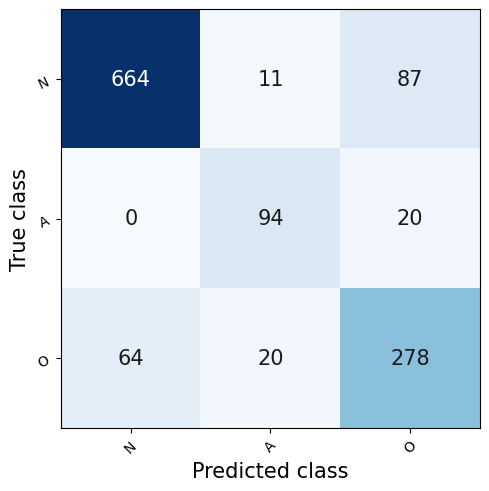

In [7]:
model = DenseNetGruEcgModule.load_from_checkpoint(checkpoint_callback.last_model_path)
_ = trainer.test(model, dataloaders=dm)

# classification report
print(classification_report(model.test_y_true_log, model.test_y_hat_log, target_names=dm.test_set.classes))

# confusion matrix
fig, ax = model.test_cm.plot(
    model.test_cm_log, cmap="Blues", labels=dm.test_set.classes
)
plt.show()

if wandb_mode != 'disabled':
    wandb.log({"test_cm": fig})
    

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 20/20 [00:00<00:00, 24.39it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8319870829582214     │
│          test_f1          │    0.7969775199890137     │
│         test_loss         │     0.431570827960968     │
└───────────────────────────┴───────────────────────────┘

              precision    recall  f1-score   support

           N       0.90      0.89      0.89       762
           A       0.77      0.77      0.77       114
           O       0.72      0.73      0.73       362

    accuracy                           0.83      1238
   macro avg       0.80      0.80      0.80      1238
weighted avg       0.83      0.83      0.83      1238



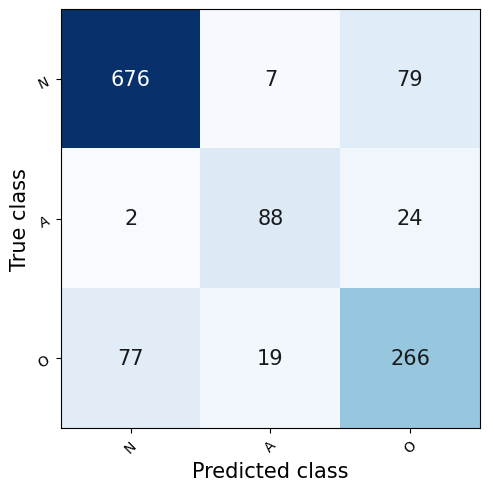

In [8]:
model = DenseNetGruEcgModule.load_from_checkpoint(checkpoint_callback.best_model_path)
_ = trainer.test(model, dataloaders=dm)

# classification report
print(classification_report(model.test_y_true_log, model.test_y_hat_log, target_names=dm.test_set.classes))

# confusion matrix
fig, ax = model.test_cm.plot(
    model.test_cm_log, cmap="Blues", labels=dm.test_set.classes
)
plt.show()

if wandb_mode != 'disabled':
    wandb.log({"test_cm": fig})

In [9]:
wandb.finish()

epoch,▁▁▁▂▂▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇██
lr,████████████████████▃▃▃▃▃▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁
test_acc,█▁
test_f1,█▁
test_loss,█▁
train_acc,▁▂▃▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████████
train_f1,▁▂▃▄▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███████████████████
train_loss,█▇▆▅▄▄▄▃▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇████
valid_acc,▁▅▆▆▇▇▇▇▇▇▇▇██▇▇█▇▇▇▇███▇██████▇▇███████
valid_f1,▁▄▅▆▆▇▇▇▇█▇▇▇▇▇▇▇▇█▇██▇█████▇███████████
